# Solvers

This notebook will focus on various least-squares and L1 solvers and show how an apparently ill-posed problem can be solved by adding additional (prior) information to the problem.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from scipy.linalg import lstsq, toeplitz, cholesky
from pylops import LinearOperator
from pylops.utils import dottest

## Problem definition

The problem that we are going to consider is generally referred to
as the *data reconstruction* problem and aims at reconstructing a regularly
sampled signal of size $M$ from $N$ randomly selected samples:

\begin{align}\mathbf{d} = \mathbf{R} \mathbf{m}\end{align}

where the restriction operator $\mathbf{R}$ that selects the $M$
elements from $\mathbf{m}$ at random locations is implemented using `pylops.Restriction`, and

\begin{align}\mathbf{d}= [d_1, d_2,...,d_N]^T, \qquad
    \mathbf{m}= [m_1, m_2,...,m_M]^T, \qquad\end{align}

with $M>>N$.

Let's first create the data in the frequency domain. The data is composed
by the superposition of 3 sinusoids with different frequencies. We then use the `pylops.FFT` operator to obtain the time domain version of the signal.

In [14]:
# input signal parameters
ifreqs = [41, 25, 66]
amps = [1., 1., 1.]
nt = 200
nfft = 2**11
dt = 0.004
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# input signal in frequency domain
X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = amps

# input signal in time domain
FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
x = FFTop.H*X

We now define the locations at which the signal will be sampled, apply forward, adjoint and inverse

In [15]:
# sampling locations    
perc_subsampling = 0.2
ntsub = int(np.round(nt*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nt))[:ntsub])

# create operator
Rop = pylops.Restriction(nt, iava, dtype='float64')

# create noise
sigma=0.01
n = np.random.normal(0, sigma, nt)

# apply forward
y = Rop*x
yn = Rop*(x + n)
ymask = Rop.mask(x)
ynmask = Rop.mask(x + n)

# apply adjoint
xadj = Rop.H*yn

# apply inverse
xinv = Rop / yn

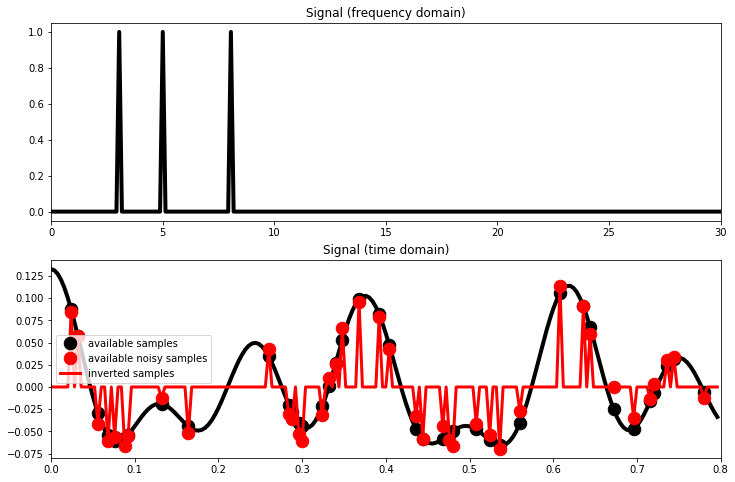

In [16]:
# Visualize
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(f, np.abs(X), 'k', lw=4)
axs[0].set_xlim(0, 30)
axs[0].set_title('Signal (frequency domain)')
axs[1].plot(t, x, 'k', lw=4)
axs[1].plot(t, ymask, '.k', ms=25, label='available samples')
axs[1].plot(t, ynmask, '.r', ms=25, label='available noisy samples')
axs[1].plot(t, xinv, 'r', lw=3, label='inverted samples')
axs[1].legend()
axs[1].set_title('Signal (time domain)')
axs[1].set_xlim(0, 0.8);

We see that solving the problem without providing any additional (prior) information does not provide a satisfactory estimate of the original (finely sampled) signal

## Problem solution

### Regularized inversion

First of all we add a second term to the cost function imposing minimum second order derivative of the model. This is equivalent to minimizing the roughness of the reconstruction, leading to a smooth estimate:

$$
\begin{bmatrix}
            \mathbf{R}    \\
            \epsilon \nabla
\end{bmatrix} \mathbf{m} =
\begin{bmatrix}
    \mathbf{d}    \\
    \mathbf{0}
\end{bmatrix}
$$

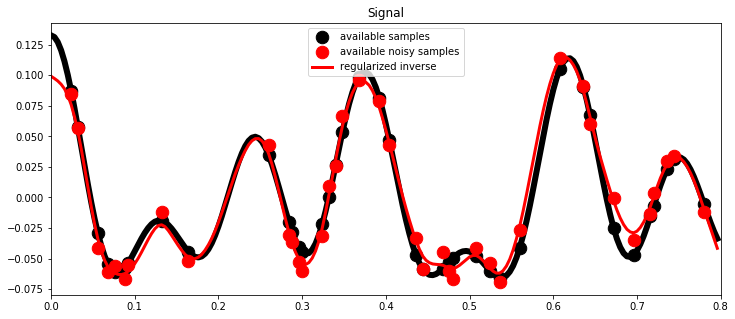

In [17]:
D2op = pylops.SecondDerivative(nt, dims=None, dtype='float64')
epsR = np.sqrt(1e1)
epsI = np.sqrt(1e-4)

xne = \
    pylops.optimization.leastsquares.RegularizedInversion(Rop, [D2op], yn,
                                                          epsRs=[epsR],
                                                          returninfo=False,
                                                          **dict(iter_lim=100, damp=epsI))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xne, 'r', lw=3, label='regularized inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

### Bayesian inversion

Let's consider now the same problem, but we frame in a Bayesian context:

$$
\begin{bmatrix}
            \mathbf{C}^{-1/2}_d \mathbf{R}    \\
            \mathbf{C}^{-1/2}_{m} \\
\end{bmatrix} \mathbf{m} =
\begin{bmatrix}
    \mathbf{C}^{-1/2}_d \mathbf{d}    \\
    \mathbf{C}^{-1/2}_{m} \mathbf{m}_0
\end{bmatrix}
$$

whose solution is:

$$\mathbf{m} = (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{R} + \mathbf{C}^{-1}_m)^{-1} (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{d} + \mathbf{C}^{-1}_m \mathbf{m_0})$$

where:

$$\mathbf{C}_d = \sigma^2 \mathbf{I} \quad (\mathbf{C}^{-1/2}_d  = 1/\sigma \mathbf{I})$$,

$$\mathbf{C}_m = \mathbf{C}_m^{\sigma^{1/2}} \mathbf{C}_m^{\rho} \mathbf{C}_m^{\sigma^{1/2}} \quad (\mathbf{C}^{-1/2}_m  = (\mathbf{C}_m^{\sigma^{-1/2} })^T \mathbf{C}_m^{\rho^{-1/2}})$$,

$$\mathbf{m}_0 = 0.05 \mathbf{I}$$

Here $\mathbf{C}_m^{\sigma^{1/2}} = \sigma_m \mathbf{I}$ and $\mathbf{C}_m^{\rho} = (\mathbf{C}_m^{\rho^{1/2}})^T \mathbf{C}_m^{\rho^{1/2}}$, where $\mathbf{C}_m^{\rho^{1/2}}$ is a convolutional matrix with a given correlation shape (e.g., exponentional)

First of all we deal with the model prior 

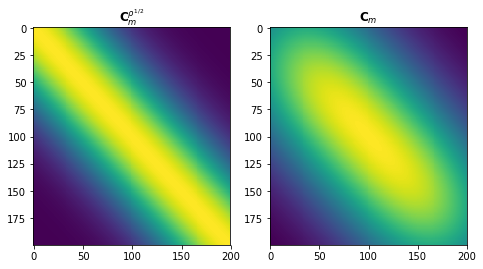

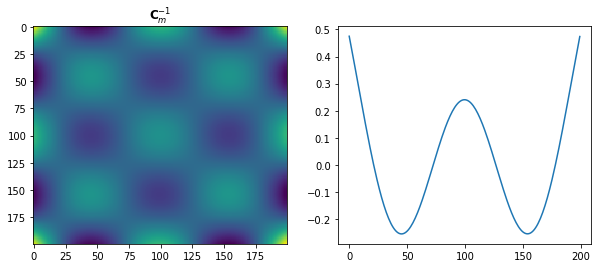

In [18]:
# Mean
x0 = 0.1 * np.ones_like(x)

# Correlation and covariance functions
corrrange = .5
sigma_m = 1e-1
taxis = np.arange(nt)*dt

corr_sqrt = np.exp(-3*(taxis)**2/corrrange**2)
Corr_sqrt = toeplitz(corr_sqrt)
Corr = np.dot(Corr_sqrt.T, Corr_sqrt)
Std = np.diag(sigma_m*np.ones(Corr.shape[0]))
Cov = np.dot(Std, np.dot(Corr, Std))

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
ax1.imshow(Corr_sqrt, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{\rho^{1/2}}$")
ax1.axis('tight')
ax2 = plt.subplot(132)
ax2.imshow(Corr, interpolation='nearest')
ax2.set_title(r"$\mathbf{C}_m^{\rho}$")
ax2.axis('tight')
ax3 = plt.subplot(132)
ax3.imshow(Cov, interpolation='nearest')
ax3.set_title(r"$\mathbf{C}_m$")
ax3.axis('tight');

# Inverse
Corr_sqrt_inv = np.linalg.pinv(Corr_sqrt, rcond=1e-5)
Corr_inv = np.linalg.pinv(Corr, rcond=1e-5)
Cov_inv = np.linalg.pinv(Cov, rcond=1e-5)

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.imshow(Cov_inv, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{-1}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(Cov_inv[nt//2]);

We see that the inverse is very ill-posed. Alternatively, we directly define the inverse as a roughening operator

In [19]:
Cov_inv = -np.diag(np.ones(nt-1),k=1) + 2*np.diag(np.ones(nt)) - np.diag(np.ones(nt-1),-1) 
Cov_inv = 1e-1*np.dot(Cov_inv.T, Cov_inv)

Let's start by solving the problem explicitely

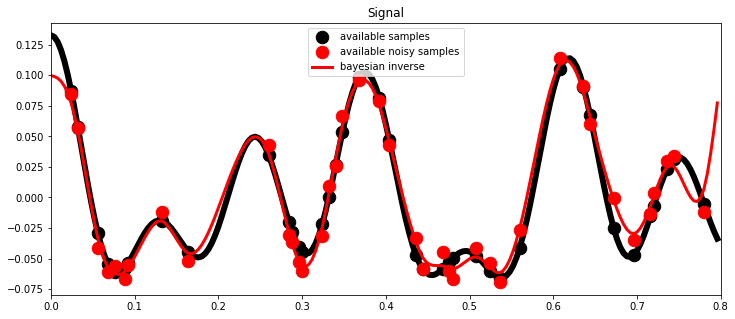

In [20]:
sigma = 1e1
Cd_inv = (1./sigma**2) * np.eye(ntsub)
Cd_half_inv = (1./sigma) * np.eye(ntsub)

# Problem
R = np.zeros((ntsub, nt))
R[np.arange(ntsub), iava] = 1

xbayes = lstsq(np.dot(R.T, np.dot(Cd_inv, R)) + Cov_inv, 
               np.dot(R.T, np.dot(Cd_inv, yn)) + np.dot(Cov_inv, x0), cond=1e-10)[0]

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

Since we however do not want to create those matrices explicitely we create equivalent linear operators

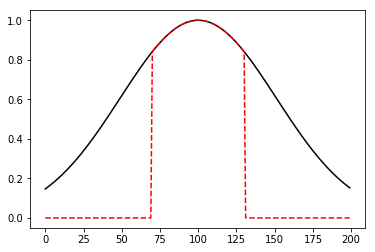

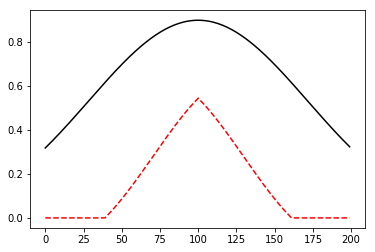

In [9]:
Corr_sqrt_op = pylops.signalprocessing.Convolve1D(nt, Corr_sqrt[nt//2, nt//2-30:nt//2+31], offset=30)
Std_op = sigma_m * pylops.Identity(nt)
Cov_sqrt_op = Corr_sqrt_op * Std_op 

x= np.zeros(nt)
x[nt//2] = 1

y = np.dot(Corr_sqrt, x)
yop = Corr_sqrt_op * x

y2 = np.dot(Corr, x)
y2op = Corr_sqrt_op.H * Corr_sqrt_op * x

y2 = np.dot(Cov, x)
y2op = Std_op.H * Corr_sqrt_op.H * Corr_sqrt_op * Std_op * x

plt.figure()
plt.plot(y, 'k')
plt.plot(yop, '--r')

plt.figure()
plt.plot(y2, 'k')
plt.plot(y2op, '--r')

Let's now deal with the data prior

In [10]:
Cd_12 = (1./sigma) * pylops.Identity(nt)

In [11]:
xbayes = \
    pylops.optimization.leastsquares.RegularizedInversion(Rop, [Cm_12], y,
                                                          Weight=Cd_12,
                                                          epsRs=[1.],
                                                          returninfo=False,
                                                          **dict(iter_lim=100, damp=epsI))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, xreg, 'r', lw=3, label='regularized inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8)

NameError: name 'Cm_12' is not defined

### Preconditioned inversion

Back to deterministic inversion, we add now a preconditioner imposing smoothness in the solution:

$$\mathbf{d} = \mathbf{R}  \mathbf{S} \mathbf{z}$$

where $\mathbf{m} = \mathbf{P} \mathbf{z}$

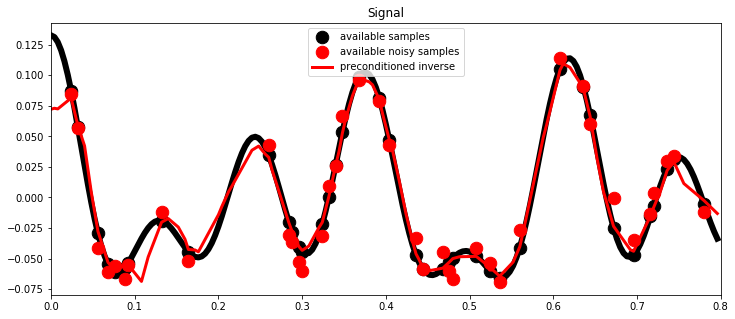

In [21]:
Sop  = pylops.basicoperators.Smoothing1D(nsmooth=21, dims=[nt], dtype='float64')

xprec = \
    pylops.optimization.leastsquares.PreconditionedInversion(Rop, Sop, y, returninfo=False,
                                                             **dict(damp=np.sqrt(1e-3), iter_lim=100, show=0))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xprec, 'r', lw=3, label='preconditioned inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

### Sparse solver

To conclude we use a sparse solver. We assume knowledge about the modelling process: the input signal was created in the frequency domain as summation of three sinusoids. We can thus assume the signal Fourier representation will be sparse (i.e, just a few spikes at the correct frequencies). 

In mathematical terms, solving for a sparse model is equivalent to add a regularization terms that requires to minimize the $L_1$ norm of the model:

$$ ||\mathbf{p}||_1 \qquad subject \quad to \qquad  \mathbf{d} = \mathbf{R} \mathbf{S} \mathbf{z} $$ 

Restoring best iterate to objective 0.04812679709843937


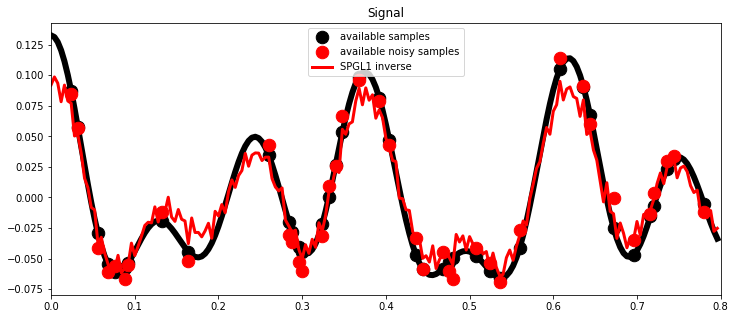

In [28]:
# sparse inversion
xspgl1, zspgl1, info = pylops.optimization.sparsity.SPGL1(Rop, yn, FFTop, tau=3, iter_lim=50)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xspgl1, 'r', lw=3, label='SPGL1 inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

In [ ]:
scooby.Report(core='pylops')